# Setup

In [1]:
!pip install stochastic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 KB 2.1 MB/s eta 0:00:00


In [2]:
from stochastic.processes.continuous import FractionalBrownianMotion
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import display, clear_output
import torch
import time

# Simulate FBM

In [3]:
class FBM_Simulator():
    """
    Simulates Fractional Brownian Motion (FBM) agents on a rectangular plane with equal
    relative spacing between squares. The class determines the size of the squares based on
    the values of 'plane_size', 'grid_shape', and 'neuron_spacing'. It also adds a border
    around the rectangle plane with a width of square edge / 2. The class generates 'n_fibers'
    number of random coordinates in the rectangle and simulates an FBM agent from each
    coordinate with a Hurst exponent of 'hurst'. The time of each FBM path is set to 'T'.
    The class uses standard FBM (σ = 1) and sets the time-distance between two consecutive
    points in FBM paths to 'deltaT'. The length of the moving fiber, in points, is set to
    'fiber_length' and the speed (offset) of fibers in each iteration, in points, is set to
    'fiber_speed'. The factor that translates the FBM-path coordinates to the rectangle
    coordinates (fbmToRec) is also set.

    Methods:
        __init__(self, plane_size: tuple, grid_shape: tuple, spacing: float, hurst: float, n_fibers: int, fiber_length: int, T: float, deltaT = None, fiber_speed = 1): Initializes the FBM_Simulator with the given parameters. Builds up the core FBM agent in X and Y dimensions.
        forward(self): Returns input * mask * scale, where input is the current iteration of the simulation, mask is the generated mask for the current iteration, and scale is the inverse of the current dropout rate.
        update_dropout_rate(self): Calculates and updates the current and cumulative dropout rates.
        create_grid(self): Creates the rectangular grid with the specified attributes and returns a dictionary of tuples representing the grid.
        make_mask(self): Generates a binary mask that selects neurons within the bounding box of each FBM agent.

    Parameters:
        plane_size (tuple): Tuple of two integers representing the size of the plane in X and Y dimensions.
        grid_shape (tuple): Tuple of two integers representing the number of rows and columns in the rectangular grid.
        spacing (float): Float representing the spacing between neurons.
        hurst (float): Float representing the Hurst parameter used in the FBM agent.
        n_fibers (int): Integer representing the number of FBM agents.
        fiber_length (int): Integer representing the number of points in each FBM agent.
        T (float): Float representing the time parameter for the FBM agent.
        deltaT (float): Float representing the time step for the FBM agent. Default value is None.
        fiber_speed (int): Integer >=1 representing the speed of the FBM agent. Default value is 1.
        max_iters: (int): Integer representing the maximum number of forward calls during each epoch. Default value is 1000.
        fiber_size: (float): Float representing the width of the fibers for visualization. Default value is 1.5.
    """

    def __init__(self, plane_size: tuple, grid_shape: tuple, spacing: float, hurst: float, 
                 n_fibers: int, fiber_length: int, T: float, deltaT = None, fiber_speed = 1,
                 max_iters: int = 1000, fiber_size: float = 1.5):
        """
        Initializes the FBM_Simulator with the given parameters.
        Build up the core Fractional Brownian Motion agent in X and Y dimentations
        """

        # Getting started
        self.plane_size = plane_size
        self.grid_shape = grid_shape
        self.neuron_spacing = spacing
        self.hurst = hurst
        self.n_fibers = n_fibers
        self.fiber_length = fiber_length
        self.T = T
        self.deltaT = deltaT
        self.grid = None
        self.fbm_paths = None
        self.squares_touched = None

        # Making one long fiber
        self.agents_x = []
        self.agents_y = []
        self.colors = []

        # keeping track of cummulative dropout rate and iters
        self.current_iter = 0
        self.total_iter = 0
        self.sum_dropout_rate = 0.0
        self.cum_dropout_rate = 0.0

        ## Maximum number of iterations during each epoch
        self.max_iters = max_iters

        self.fiber_size = fiber_size
        self.fiber_speed = fiber_speed

        # initialize (x, y) of FBM dropout agents for max iterations and their color
        for _ in range(self.n_fibers):
            # random starting point (x, y)
            x_starting_pt = int(torch.rand((1,)).item() * self.plane_size[0])
            y_starting_pt = int(torch.rand((1,)).item() * self.plane_size[1])
            # get x FBM sequence with periodic boundary at [0, 1]
            fbm_x = FractionalBrownianMotion(hurst, t=self.T)
            self.agents_x.append((fbm_x.sample(self.max_iters * self.fiber_length) + x_starting_pt) % plane_size[0])
            # get y FBM sequence with periodic boundary at [0, 1]
            fbm_y = FractionalBrownianMotion(hurst, t=self.T)
            self.agents_y.append((fbm_y.sample(self.max_iters * self.fiber_length) + y_starting_pt) % plane_size[1])
            # get random (r, g, b) color
            color = torch.rand((3,))
            color = (color[0].item(), color[1].item(), color[2].item())
            self.colors.append(color)

        if self.n_fibers == 1:
            self.colors[0] = 'blue'

        ## n_fibers = len(self.agents_x) = len(self.agents.y) = len(colors)
        
        # initialize the grid of neurons
        self.grid = self.create_grid()

    def forward(self):
        """
        Advances the state of the simulation by one iteration. Moves each fiber
        along its path according to the set speed and updates the list of neurons
        touched by each fiber.
        """
        
        # get new mask
        self.mask = self.make_mask()

        # update iters
        self.current_iter += 1
        self.total_iter += 1
        # update dropout rates
        self.update_dropout_rate()

        # return input * mask * scale        
        # return torch.mul(input, self.mask) * (1 / (1 - self.now_dropout_rate))

    def update_dropout_rate(self):
        """
        Updates the dropout rate of each neuron based on the mask of touched neurons.
        The dropout rate of each neuron is calculated as the fraction of total iterations
        in which the neuron was touched by any fiber. The dropout rates are averaged
        over all iterations so far and stored in 'cum_dropout_rate'. The total number of
        iterations so far is stored in 'total_iter'. Also, the current iteration counter
        'current_iter' is reset to 0.
        
        Parameters:
            mask (torch.Tensor): A mask of zeros and ones that covers the grid of neurons.
        """

        self.current_dropout_rate = self.get_dropout_rate()
        self.sum_dropout_rate += self.current_dropout_rate
        self.cum_dropout_rate = self.sum_dropout_rate / self.total_iter

    def get_dropout_rate(self):
        """
        The dropout rate of each neuron is calculated as the fraction of total iterations
        in which the neuron was touched by any fiber.

        Returns:
        -------
        A float representing the current dropout rate
        """

        return (1 - (torch.sum(self.mask) / (self.n_col * self.n_row))).item()

    def create_grid(self):
        """
        Create the rectangular grid with the specified attributes
        
        Returns:
        -------
        A dict of tuples representing the grid
        """
        # Determine the size of each square
        self.n_row = self.grid_shape[0]
        self.n_col = self.grid_shape[1]

        size_row = self.plane_size[0] / self.n_row
        size_col = self.plane_size[1] / self.n_col

        gap_y = self.neuron_spacing / 2
        gap_x = self.neuron_spacing / 2

        grid = {}
        for x in range(self.n_col):
            for y in range(self.n_row):
                x_low = (x * size_col) + (gap_y * size_col / (1 + self.neuron_spacing))
                y_low = (y * size_row) + (gap_x * size_row / (1 + self.neuron_spacing))
                x_high = x_low + size_col / (1 + self.neuron_spacing)
                y_high = y_low + size_row / (1 + self.neuron_spacing)
                grid[(x,y)] = ((x_low, x_high), (y_low, y_high))

        self.grid = grid
        
        return grid

    def make_mask(self):
        """
        Creates a mask of zeros and ones that covers the grid of neurons, where
        ones indicate the neurons that have been touched by any fiber in the current
        iteration. The mask is used to update the dropout rate of each neuron.
        
        Parameters:
            touched_neurons (list): A list of neuron positions touched by each fiber.
            
        Returns:
            torch.Tensor: A mask of zeros and ones that covers the grid of neurons.
        """
        
        def is_in(agent_x, agent_y, g):
            # bounding box for a neuron
            ((x_low, x_high), (y_low, y_high)) = g
            # check if (x, y) is within the bounding box 
            for x,y  in zip(agent_x, agent_y):
                if x_low <= x and x <= x_high and y_low <= y and y <= y_high:
                    return True
            return False

        # initialize a mask
        make_mask = torch.ones(self.grid_shape)
        t = self.current_iter * self.fiber_length

        # get (x, y) for current iteration
        self.curr_agents_x = [agent_x[t+self.fiber_speed:t+ np.square(self.fiber_length)+self.fiber_speed] for agent_x in self.agents_x]
        self.curr_agents_y = [agent_y[t+self.fiber_speed:t+ np.square(self.fiber_length)+self.fiber_speed] for agent_y in self.agents_y]
        # print(len(self.curr_agents_x[1]))
        # set make_mask[(i,j)] to 0 if (x,y) is within neuron (i,j)
        for i in range(self.n_col):
            for j in range(self.n_row):
                for x, y in zip(self.curr_agents_x, self.curr_agents_y):
                    if is_in(x, y, self.grid[(i,j)]):
                        make_mask[(j,i)] = 0

        
        self.make_mask_ = make_mask
        self.t = t

        # rotate 90 degrees
        make_mask = torch.rot90(make_mask)
        # if self.is_conv:
        #     return make_mask
        # flatten for linear layer
        return make_mask.reshape(-1)

    def viz_grid(self, title=None, dpi=300, show_history=False):
        """
        Visualize the grid using matplotlib
    
        Parameters:
        ----------
        grid : list of lists
            A rectangular grid of squares represented by a list of lists
    
        Returns:
        -------
        None
        """

        if show_history:
            # get (x, y) for all previous iterations
            prev_agent_x = [agent_x[:self.t] for agent_x in self.agents_x]
            prev_agent_y = [agent_y[:self.t] for agent_y in self.agents_y]
        # print the current grid status
        _, ax = plt.subplots(tight_layout=True, facecolor=(1, 1, 1))
        # print the agents

        for i in range(self.n_fibers):
            if show_history:
                ax.scatter(prev_agent_x[i], prev_agent_y[i], s=3, color=self.colors[i], alpha=0.3, linewidths=self.fiber_size)
            ax.scatter(self.curr_agents_x[i], self.curr_agents_y[i], s=10, color=self.colors[i], linewidths=self.fiber_size)
        # print the neurons
        for x in range(self.n_col):
            for y in range(self.n_row):
                ((x_low, x_high), (y_low, y_high)) = self.grid[(x,y)]
                if self.make_mask_[(y,x)]:
                    # set to black if not dropped out
                    facecolor = 'black'
                else:
                    # set to red if dropped out
                    facecolor = 'red'
                ax.add_patch(Rectangle((x_low, y_low), x_high - x_low, y_high - y_low,
                                        facecolor=facecolor, zorder=0))
        ax.set_aspect('equal')
        ax.set_xlim(0, self.plane_size[1])
        ax.set_ylim(0, self.plane_size[0])
        #ax.set_title('Dropout rate: {:2f}'.format(self.now_dropout_rate))
        if title:
            plt.savefig(title, dpi=dpi, bbox_inches='tight')

        plt.tick_params(left = False, right = False , labelleft = False ,
                        labelbottom = False, bottom = False)
        
        clear_output(wait = True)
        plt.pause(.2)

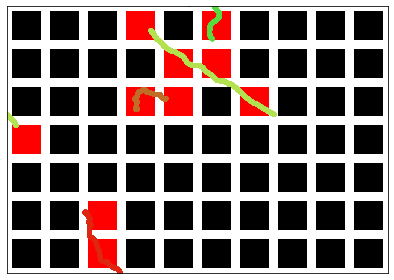

In [20]:
rg = FBM_Simulator(plane_size= (70, 100), grid_shape= (7, 10), spacing= .3, hurst= .95, n_fibers= 5, fiber_length= 200, T= 100, fiber_size=.5, fiber_speed=1000)

for i in range(1, 3):
    rg.forward()
    rg.viz_grid(show_history=False)

In [ ]:
agents_x = []
fbm_x = FractionalBrownianMotion(.999, t=100000/10)
agents_x.append((fbm_x.sample(100000 * 100) + 3) % 10)

/usr/local/lib/python3.8/dist-packages/stochastic/processes/noise/fractional_gaussian_noise.py:18: RuntimeWarning: invalid value encountered in sqrt
  return np.fft.irfft(_fgn_autocovariance(hurst, n))[:n] ** (1 / 2)


In [ ]:
agents_x

[array([ 3., nan, nan, ..., nan, nan, nan])]